<div>
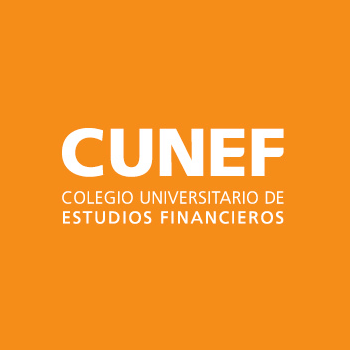
</div>


# **BioNTech SE**

## *Librerías*

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from sktime.forecasting.arima import AutoARIMA
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *Lectura del CSV y preparación del dato*
Se procede a leer el archivo CSV del precio histórico y volumen de acciones de la empresa BioNTech SE (BNTX).

- Fuente: https://finance.yahoo.com/quote/BNTX/history?period1=1570665600&period2=1651881600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [3]:
df_bntx = pd.read_csv("BNTX2.csv")
df_bntx['Date'] = pd.to_datetime(df_bntx['Date'])
df_bntx = df_bntx.set_index("Date")
df_bntx.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-10,16.50,16.698999,13.010,14.24,14.24,2805800
2019-10-11,15.34,15.340000,13.500,13.82,13.82,1364300
2019-10-14,13.83,13.910000,12.525,12.75,12.75,899100
2019-10-15,12.99,13.000000,12.530,12.92,12.92,484700
2019-10-16,13.20,13.880000,12.610,12.94,12.94,524200


Los datos bursátiles que tenemos están a diario. Podríamos descargar el CSV con dichos datos de manera mensual, pero optaremos por hacer una conversión usando la función de remuestreo (resample) que ofrece la librería Pandas.
- Fuente de información: https://stackoverflow.com/questions/28126286/convert-daily-pandas-stock-data-to-monthly-data-using-first-trade-day-of-the-mon

In [4]:
type(df_bntx) #comprobamos que en efecto es un DataFrame

pandas.core.frame.DataFrame

In [5]:
ohlc_dict = {'Open':'first',
             'High':'max',
             'Low':'min',
             'Close': 'last',
             'Volume': 'sum'}
df_bntx = df_bntx.resample('MS', # Pondremos MS en vez de M para que se ubique a primeros de mes
                           closed='right', 
                           label='right').agg(ohlc_dict)
df_bntx.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-11-01,16.500000,21.990000,12.525000,16.520000,9028800
2019-12-01,17.049999,23.400000,17.030001,21.980000,2102300
2020-01-01,22.660000,38.750000,20.719999,33.880001,4138000
2020-02-01,35.750000,48.849998,28.500000,29.209999,6224700
2020-03-01,29.799999,35.099998,28.690001,35.099998,3505700


## *Graficación de la serie temporal*

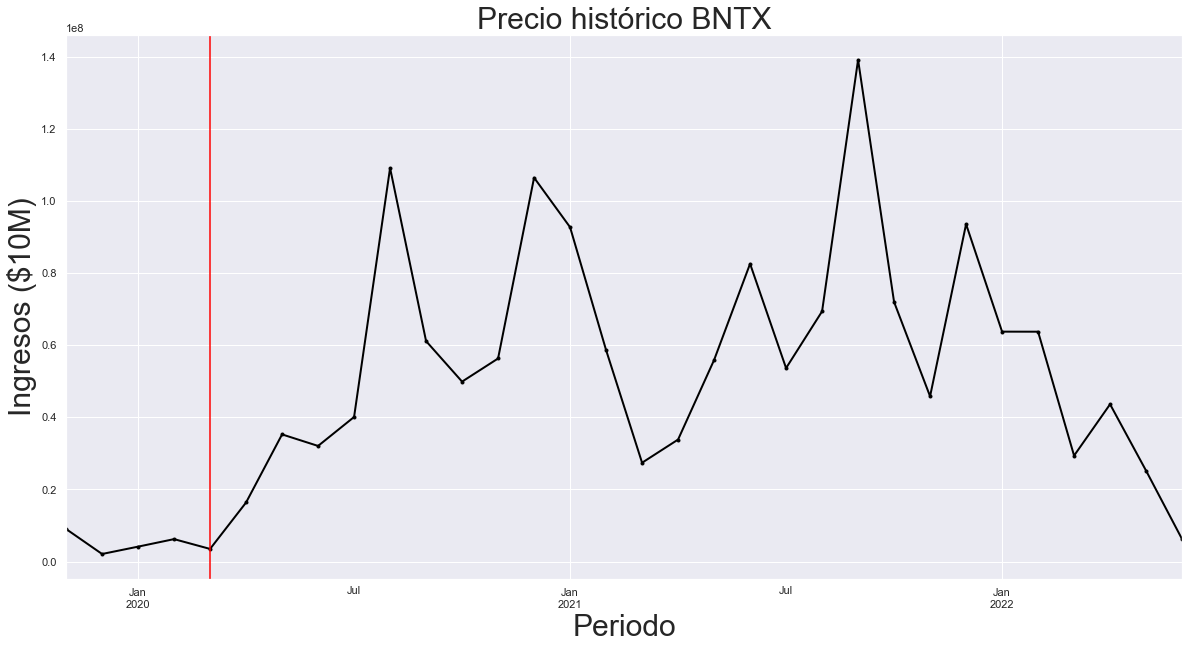

In [6]:
sns.set(rc={'figure.figsize':(20, 10)})
fig = df_bntx['Volume'].plot(marker='.', color = 'black', linewidth= 2) 
fig.set_title('Precio histórico BNTX', fontsize = 30) 
fig.set_ylabel('Ingresos ($10M)', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Periodo', fontsize = 30);

En el gráfico no se aprecia una estacionalidad muy clara, pues hay máximos y mínimos que se muestran de manera irregular a lo largo del eje del periodo. En cambio, se puede apreciar que ha habido una tendencia muy creciente desde el momento que se inicia la pandemia por COVID-19, debido a que BioNTech es una de las empresas líderes en desarrollo de vacunas y también debido a que fue (y es) una de las entidades que han apostado muchos países y muchas corporaciones para el desarrollo de la vacuna contra el Coronavirus, de ahí que el precio de las acciones se hayan podido revalorizar hasta un 700%.
- Fuente: https://www.businessinsider.es/cuanto-dinero-habrias-ganado-invertir-1000-euros-acciones-biontech-754191

A continuación, analizaremos mejor su estacionalidad y su tendencia mediante:
- Cálculo de la media y de la varianza
- Gráficas de comportamiento mensual
- Desglose de la tendencia, de la estacionalidad y residuos

Ahora vamos a hacer el cálculo y la representación gráfica de la media y de la varianza:

In [7]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

In [8]:
mean = split_and_summarize(df_bntx, 'Volume', 4, np.mean)

variance = split_and_summarize(df_bntx, 'Volume', 4, np.var)

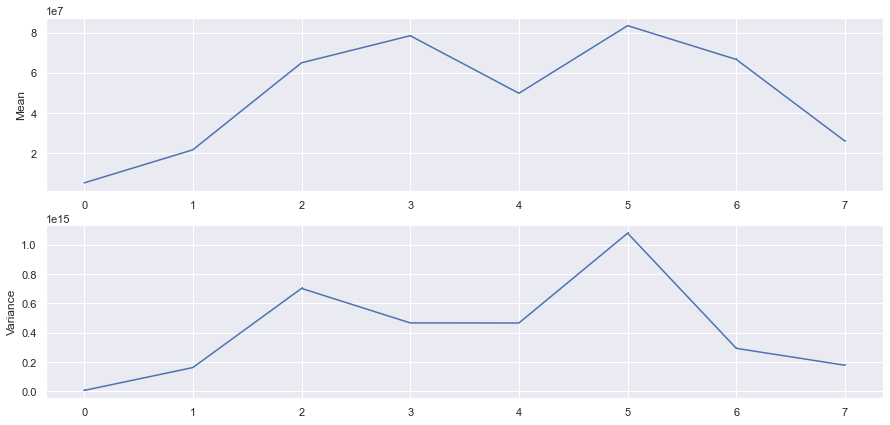

In [9]:
cols = ['mean', 'variance']
df = pd.DataFrame([mean, variance], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(mean, ',-')
ax1.set_ylabel('Mean')

ax2.plot(variance, ',-')
ax2.set_ylabel('Variance')

plt.show()

A continuación vamos a analizar el comportamiento mensual:

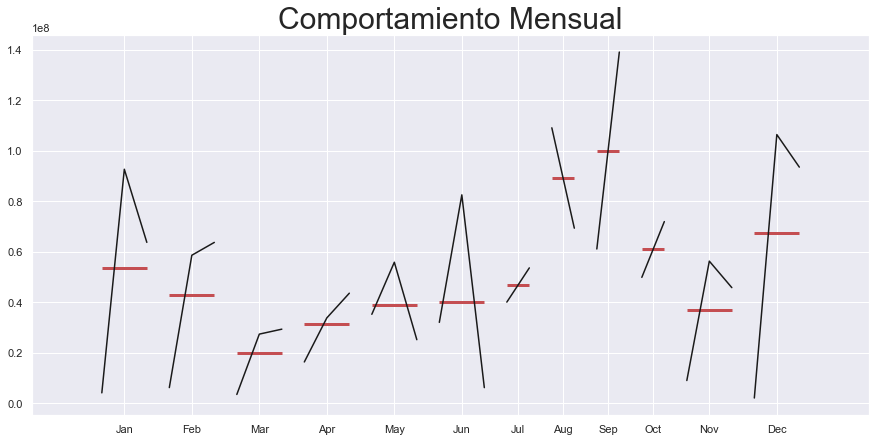

In [10]:
ax = plt.gca()
sm.graphics.tsa.month_plot(df_bntx['Volume'], ax=ax)
ax.set_title('Comportamiento Mensual', fontsize = 30);

Lo representamos también con box plots:

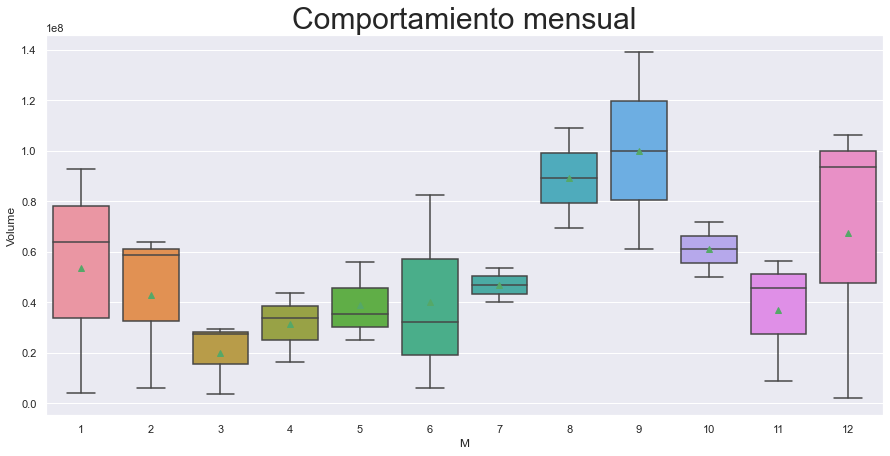

In [11]:
df_bntx['M'] = df_bntx.index.month
sns.boxplot(data = df_bntx, x = 'M', y='Volume', showmeans=True)
ax = plt.gca()
ax.set_title('Comportamiento mensual', fontsize = 30);

Por último, el desglose de la estacionalidad, de la tendencia y de los residuos para analizarlo:

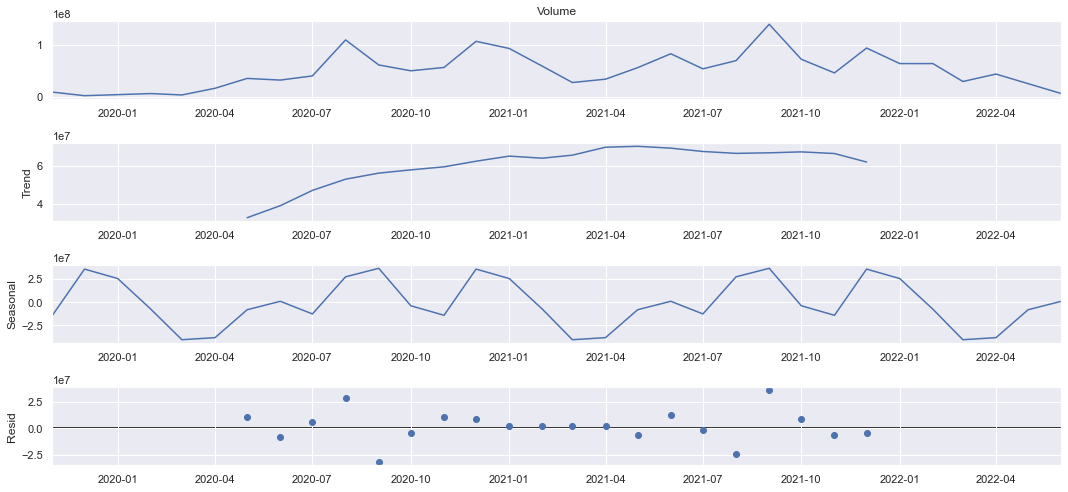

In [12]:
desglose = seasonal_decompose(df_bntx['Volume'], 
                                   model='additive', 
                                   period=12);
desglose.plot();

Como análisis, podemos decir que:
- Que hubo una tendencia creciente muy fuerte en la época del desarrollo de la vacuna Pfizer para el COVID-19 por lo que habíamos explicado anteriormente, ahora parece que está tomando una tendencia decreciente desde septiembre del 2021.
- La estacionalidad no es nada clara, se puede intuir por los comportamientos mensuales que los meses de más revalorización de BioNTech son julio y agosto, aunque en la representación de la serie temporal no se ve que se repitan dichas acentuaciones en los mismos meses del año. Por otra parte, la media y la varianza no son constantes a lo largo del periodo, de ahí que no se aprecie que ni sea una serie estacional ni que tenga estacionariedad.

## *Modelo de suavizado exponencial (ETS)*
A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en un año.

22 10


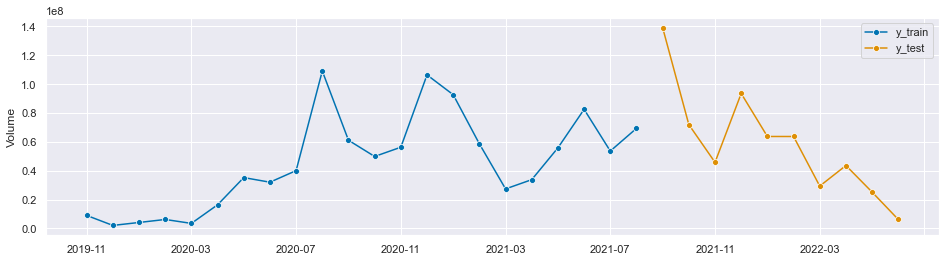

In [13]:
y_train, y_test = temporal_train_test_split(y = df_bntx['Volume'].astype('float64').to_period('M'), 
                                            test_size=10)

plot_series(y_train, y_test, labels=["y_train", "y_test"])

print(y_train.shape[0], y_test.shape[0])

Se realiza el pronóstico (forecasting) del horizonte temporal de 2 años. En sp, que es el número de periodos en un ciclo estacional completo, pondremos 12 para datos mensuales con ciclo anual:

In [49]:
fh = np.arange(1, 11)
paro_autoets = AutoETS(auto=True, 
                       sp=4, 
                       n_jobs=-1)
paro_autoets.fit(y_train)
print(paro_autoets.summary())

                                 ETS Results                                  
Dep. Variable:                 Volume   No. Observations:                   22
Model:                       ETS(MNM)   Log Likelihood                -338.275
Date:                Mon, 16 May 2022   AIC                            692.550
Time:                        08:19:43   BIC                            701.279
Sample:                    11-30-2019   HQIC                           694.607
                         - 08-31-2021   Scale                           17.827
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.1387      0.213      0.653      0.514      -0.278       0.555
smoothing_seasonal  8.613e-05      0.233      0.000      1.000      -0.456       0.457
initial_level      -

In [50]:
bntx_pred = paro_autoets.predict(fh)

print(bntx_pred)

2021-09    4.163553e+07
2021-10    6.405416e+07
2021-11    2.833060e+07
2021-12    1.599202e+08
2022-01    4.163553e+07
2022-02    6.405416e+07
2022-03    2.833060e+07
2022-04    1.599202e+08
2022-05    4.163553e+07
2022-06    6.405416e+07
Freq: M, dtype: float64


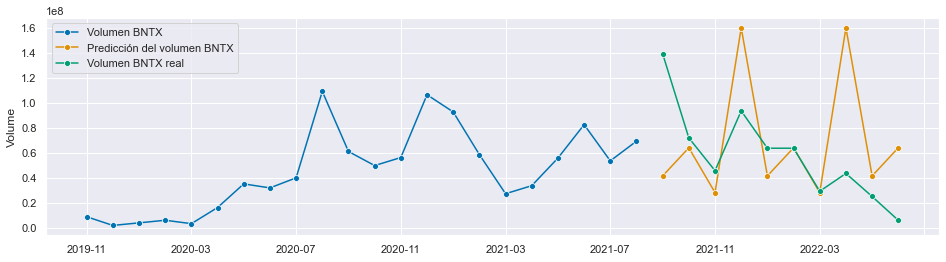

In [51]:
plot_series(y_train, bntx_pred, y_test, labels=["Volumen BNTX", 
                                                "Predicción del volumen BNTX", 
                                                "Volumen BNTX real"]);

La predicción por ETS ...  

#### *Comprobación de la precisión de las predicciones (errores):*

MAPE

In [52]:
mape = mean_absolute_percentage_error(y_test, bntx_pred)

In [53]:
mape

0.5931955160414006

MSE

In [56]:
mse = MeanSquaredError()
mse(y_test, bntx_pred)

3190820278041254.0

RMSE

In [58]:
rmse = MeanSquaredError(square_root=True)
rmse(y_test, bntx_pred)

56487346.17630088

Ahora se realiza el pronóstico (forecasting) del horizonte temporal de 2 años, o sea, para el 2024:

In [65]:
fh2 = np.arange(1, 25)

bntx_autoets_pred = AutoETS(auto=True, sp=4, n_jobs=-1)

y = df_bntx['Volume'].astype('float64').to_period('M')

bntx_autoets_pred.fit(y)

print(bntx_autoets_pred.summary())

                                 ETS Results                                  
Dep. Variable:                 Volume   No. Observations:                   32
Model:                       ETS(MAM)   Log Likelihood                 184.542
Date:                Mon, 16 May 2022   AIC                           -349.083
Time:                        08:22:37   BIC                           -334.426
Sample:                    11-30-2019   HQIC                          -344.225
                         - 06-30-2022   Scale                            2.382
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.0001      0.047      0.002      0.998      -0.093       0.093
smoothing_trend         1e-08        nan        nan        nan         nan         nan
smoothing_seasonal  

#### Predicción de las ventas los 6 futuros trimestres por modelo ETS:

In [66]:
bntx_autoets_pred.predict(fh2)

2022-07    2.683796e+08
2022-08   -2.110784e+15
2022-09   -2.102795e+15
2022-10   -1.704219e+15
2022-11    3.021641e+08
2022-12   -2.368389e+15
2023-01   -2.351827e+15
2023-02   -1.900244e+15
2023-03    3.359485e+08
2023-04   -2.625994e+15
2023-05   -2.600859e+15
2023-06   -2.096269e+15
2023-07    3.697329e+08
2023-08   -2.883598e+15
2023-09   -2.849891e+15
2023-10   -2.292295e+15
2023-11    4.035174e+08
2023-12   -3.141203e+15
2024-01   -3.098922e+15
2024-02   -2.488320e+15
2024-03    4.373018e+08
2024-04   -3.398808e+15
2024-05   -3.347954e+15
2024-06   -2.684345e+15
Freq: M, dtype: float64

La representación gráfica de las predicciones a futuro del desempleo en España hasta febrero del 2024:

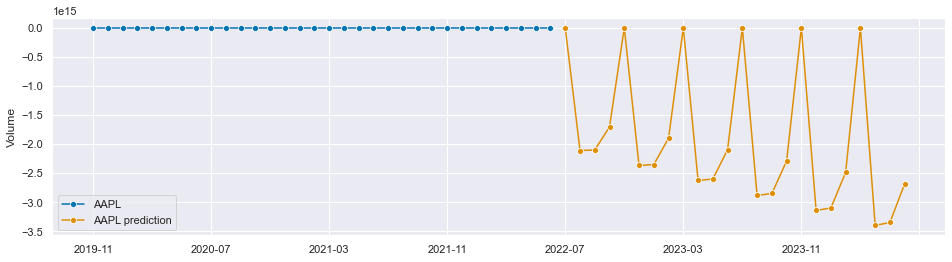

In [67]:
plot_series(y, bntx_autoets_pred.predict(fh2), labels=["AAPL", "AAPL prediction"]);

#### Estimación del modelo de forma manual:

In [68]:
forecaster = ExponentialSmoothing(trend='additive', seasonal='multiplicative', sp=12)
forecaster.fit(y)

ExponentialSmoothing(seasonal='multiplicative', sp=12, trend='additive')

In [69]:
y_pred = forecaster.predict(fh2)
y_pred

2022-07    8.601367e+06
2022-08    3.255696e+06
2022-09   -8.505659e+06
2022-10   -1.283358e+07
2022-11   -1.971581e+07
2022-12   -4.839397e+07
2023-01   -5.167801e+07
2023-02   -4.893536e+07
2023-03   -2.905602e+07
2023-04   -5.702771e+07
2023-05   -8.028506e+07
2023-06   -7.778126e+07
2023-07   -7.767996e+07
2023-08   -1.957908e+08
2023-09   -1.354996e+08
2023-10   -9.821424e+07
2023-11   -1.041000e+08
2023-12   -2.010675e+08
2024-01   -1.807729e+08
2024-02   -1.501160e+08
2024-03   -8.030330e+07
2024-04   -1.447208e+08
2024-05   -1.897184e+08
2024-06   -1.729875e+08
Freq: M, dtype: float64

In [70]:
print(forecaster._fitted_forecaster.summary())

                         ExponentialSmoothing Model Results                        
Dep. Variable:                   Volume   No. Observations:                      32
Model:             ExponentialSmoothing   SSE                 23291975045553672.000
Optimized:                         True   AIC                              1127.077
Trend:                         Additive   BIC                              1150.529
Seasonal:                Multiplicative   AICC                             1179.692
Seasonal Periods:                    12   Date:                    Mon, 16 May 2022
Box-Cox:                          False   Time:                            08:36:39
Box-Cox Coeff.:                    None                                            
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.5000000                alpha                 Tru

In [71]:
forecaster.get_fitted_params()

{'initial_level': 34942156.11111109,
 'initial_slope': None,
 'initial_seasons': array([0.8979328 , 1.61678708, 1.35037552, 0.86883477, 0.39616349,
        0.45975169, 1.021445  , 0.77848477, 0.8071244 , 1.95342558,
        1.03223297, 0.81744192]),
 'aic': 1127.076779990756,
 'bic': 1150.5285544355515,
 'aicc': 1179.6921646061405}

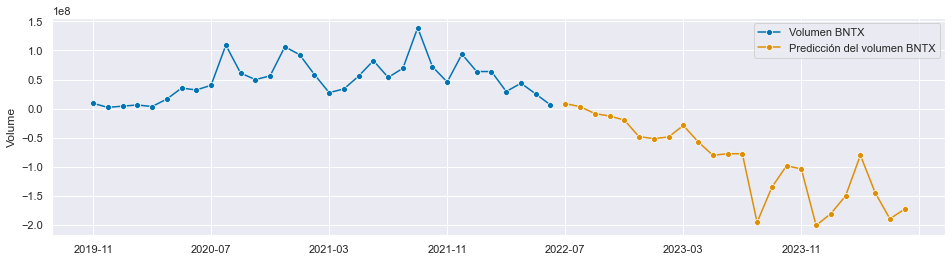

In [73]:
plot_series(y, y_pred, labels=["Volumen BNTX", "Predicción del volumen BNTX"]);

#### Estimación del modelo de forma manual (sin componente estacional):

In [79]:
forecaster = ExponentialSmoothing(trend='additive',seasonal=None, sp=4)
forecaster.fit(y)

ExponentialSmoothing(sp=4, trend='additive')

In [80]:
y_pred = forecaster.predict(fh2)

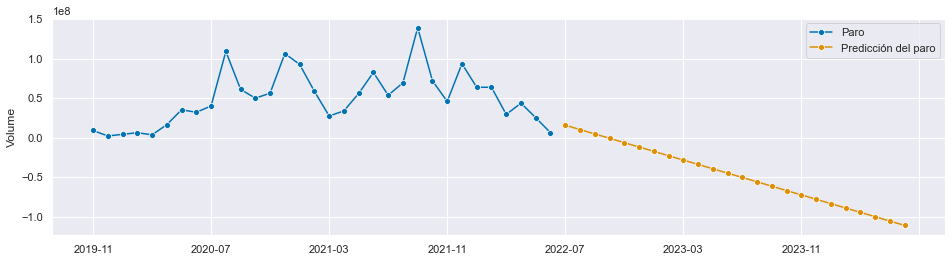

In [81]:
plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Estimación del modelo de forma manual (sin componente estacional y con tendencia multiplicativa):

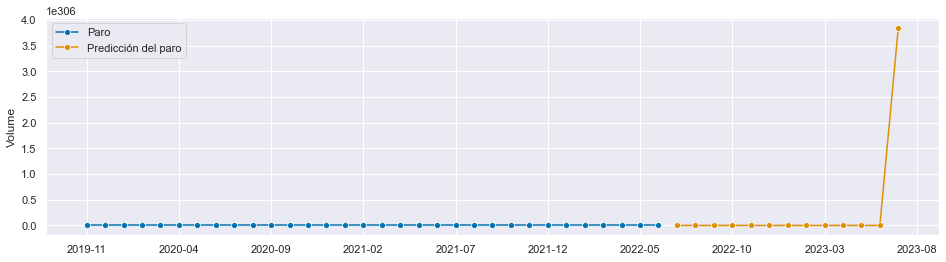

In [82]:
forecaster = ExponentialSmoothing(trend='mul',seasonal=None, sp=4)
forecaster.fit(y)
y_pred = forecaster.predict(fh2)
plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Estimación del modelo de forma manual (sin componente estacional y sin tendencia)

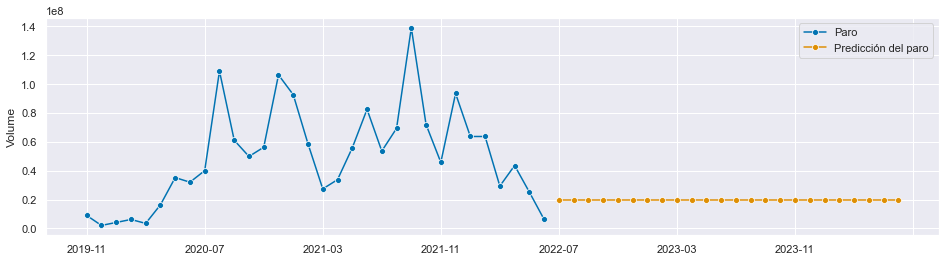

In [83]:
forecaster = ExponentialSmoothing(trend=None,seasonal=None, sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh2)
plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Estimación del modelo de forma manual (con componente estacional multiplicativo y sin tendencia):

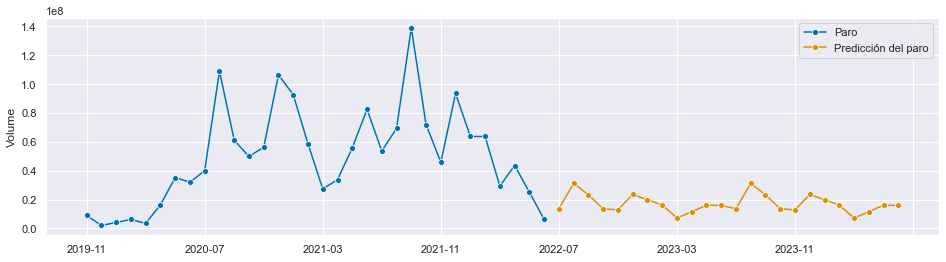

In [84]:
forecaster = ExponentialSmoothing(trend=None,seasonal="mul", sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh2)
plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Estimación del modelo de forma manual (con componente estacional aditivo y sin tendencia)

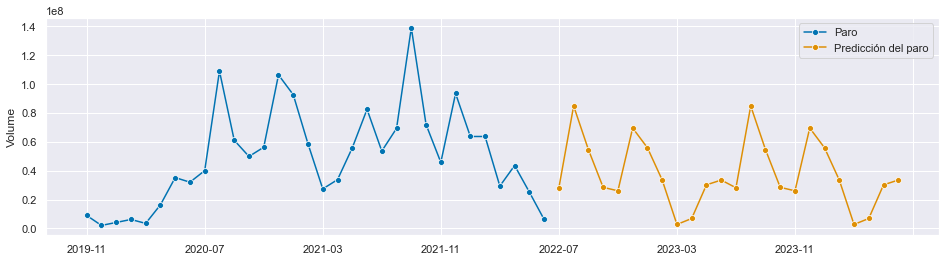

In [85]:
forecaster = ExponentialSmoothing(trend=None,seasonal="add", sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh2)
plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Comparación del modelo con componente estacional aditivo y tendencia aditiva (con y sin dumped):

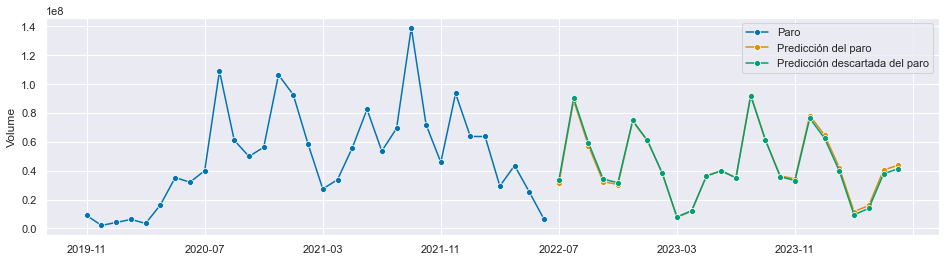

In [86]:
forecaster = ExponentialSmoothing(trend="add",seasonal="add",damped_trend=False, sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh2)

forecaster = ExponentialSmoothing(trend="add",seasonal="add",damped_trend=True, sp=12)
forecaster.fit(y)
y_pred_dump = forecaster.predict(fh2)
plot_series(y["2015":], y_pred, y_pred_dump,labels=["Paro", "Predicción del paro","Predicción descartada del paro"]);

## *Modelo ARIMA*
Vimos que la serie temporal no era estacionaria ni en su media ni en su varianza, por lo que vamos a realizar los siguientes pasos:
    
    1) comparar la transformación logarítmica de la serie original y la serie en log.
    2) calcular la autocorrelación de la serie logarítmica.
    3) aplicar el modelo ARIMA
    4) (opcional) observar la precisión de los % del error de la media absoluta y del   
    error de la media al cuadrado.

Primero hacemos un resampleo con la librería de Sktime para poder operar con sus datos:

In [54]:
# Resample to Monthly using sktime format
paro_arima = df_paro['total'].astype('float64').to_period('M').sort_index()
paro_arima.tail()

mes
2021-10    3257068.0
2021-11    3182687.0
2021-12    3105905.0
2022-01    3123078.0
2022-02    3111684.0
Freq: M, Name: total, dtype: float64

A continuación, se realiza la transformacion logarítmica de la serie original

In [58]:
transformer = LogTransformer()
log_paro = transformer.fit_transform(paro_arima)
log_paro

mes
2013-01    15.421097
2013-02    15.432961
2013-03    15.431972
2013-04    15.422785
2013-05    15.402893
             ...    
2021-10    14.996338
2021-11    14.973236
2021-12    14.948816
2022-01    14.954330
2022-02    14.950675
Freq: M, Length: 110, dtype: float64

Se comparan la **serie original** y la **serie transformada logarítmicamente** haciendo un ploteo con Sktime:

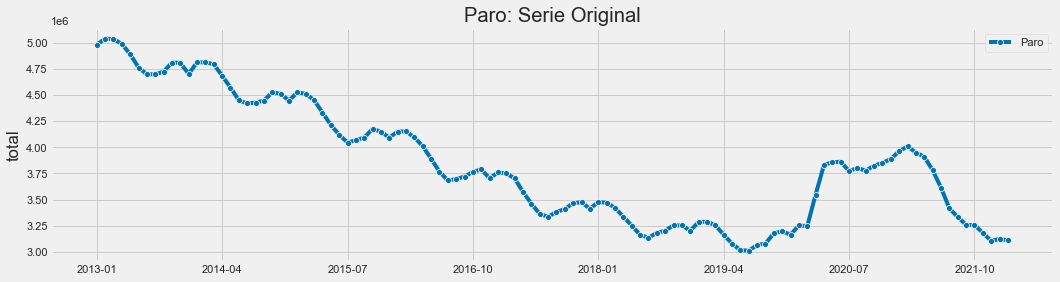

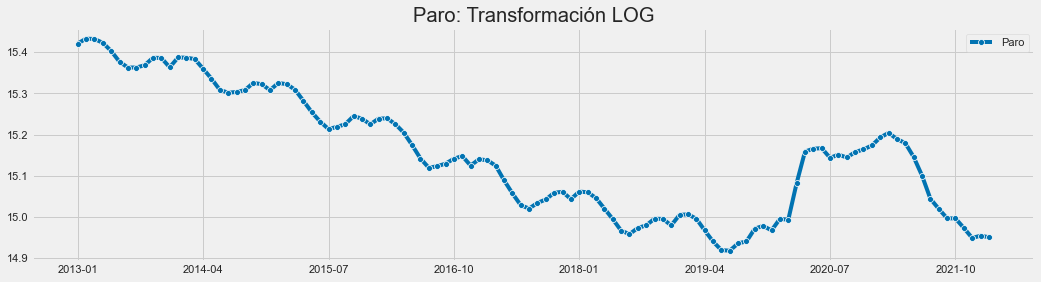

In [59]:
fig, ax =plot_series(paro_arima, labels=["Paro"])
ax.set_title('Paro: Serie Original');

fig, ax =plot_series(log_paro, labels=["Paro"])
ax.set_title('Paro: Transformación LOG');

Ahora pasamos al siguiente paso, que es realizar un **cálculo de la autocorrelación de la serie en logaritmos**:

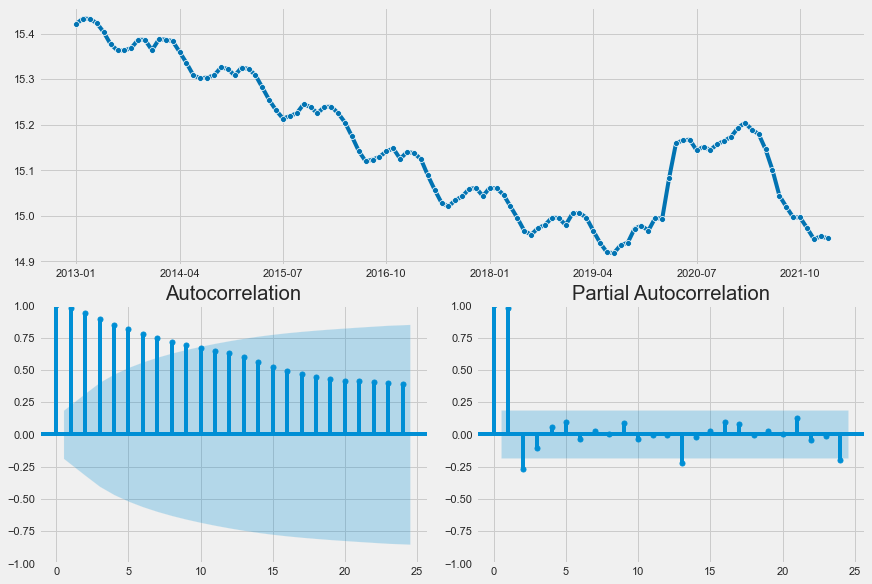

In [60]:
plot_correlations(log_paro);

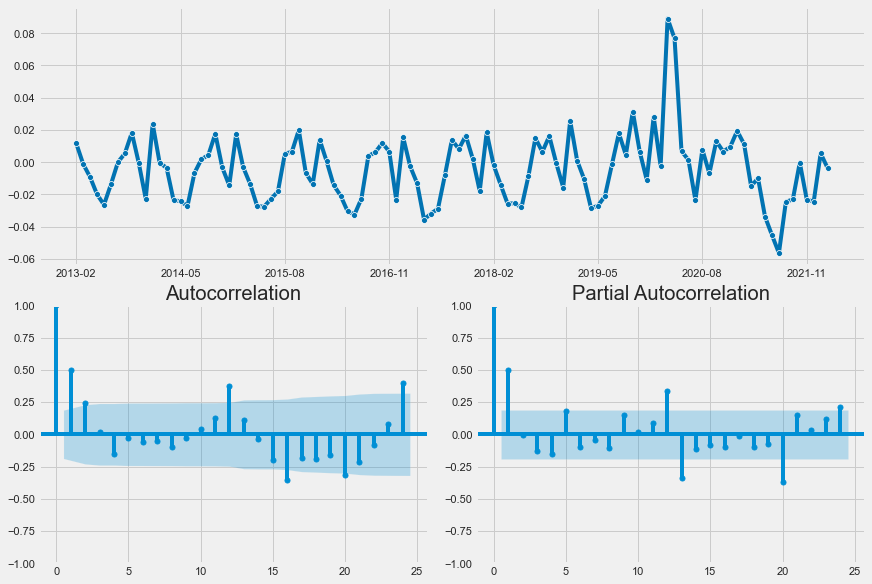

In [61]:
# Función de autocorrelación:
# Parámetros: d=1; D=0; S=4

transf_diff=Differencer(lags=[1])
plot_correlations(transf_diff.fit_transform(log_paro));

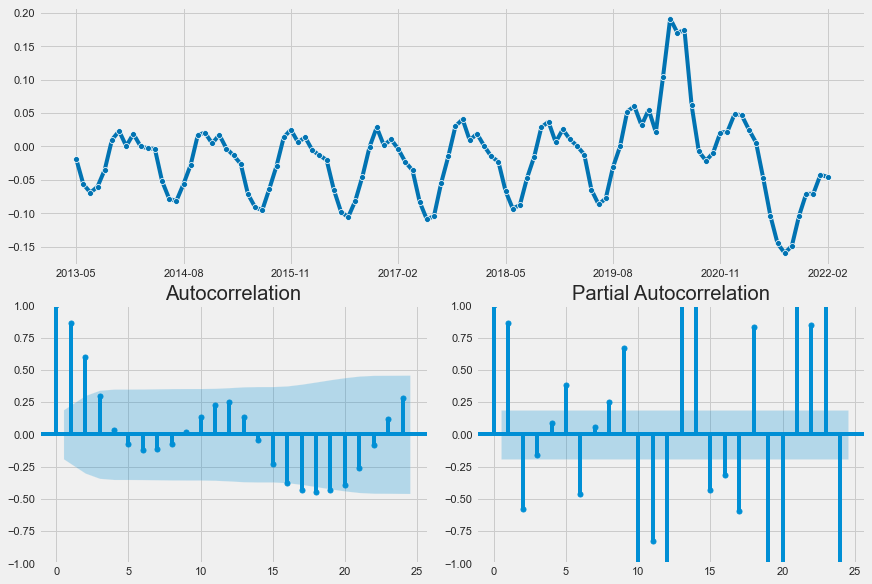

In [62]:
# Función de autocorrelación:
# Parámetros: d=0; D=1; S=4

transf_diff=Differencer(lags=[4])
plot_correlations(transf_diff.fit_transform(log_paro));

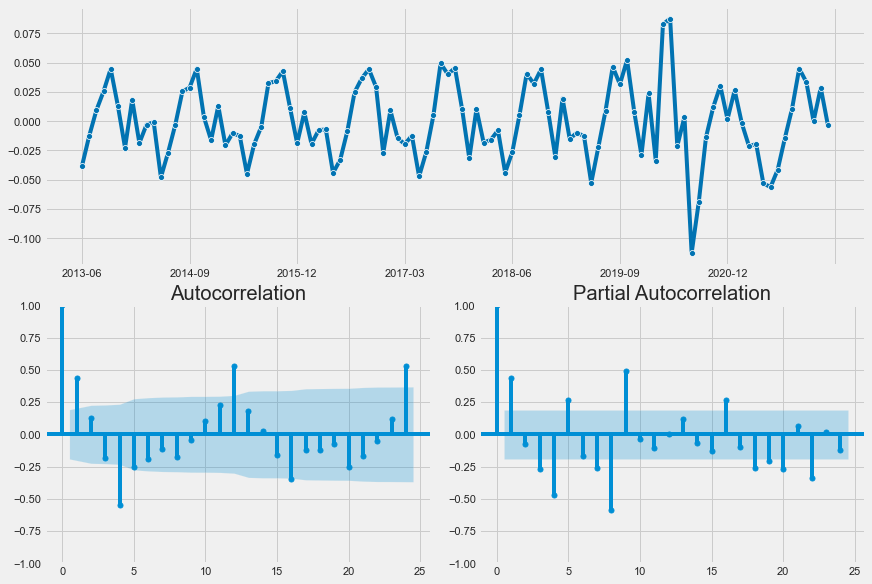

In [63]:
# Función de autocorrelación:
# Parámetros: d=1; D=1; S=4

transf_diff=Differencer(lags=[1,4])
plot_correlations(transf_diff.fit_transform(log_paro));

Como se hizo anteriormente, se separa la muestra en la parte de estimación (Training) y la parte de predicción (Testing):

102 8


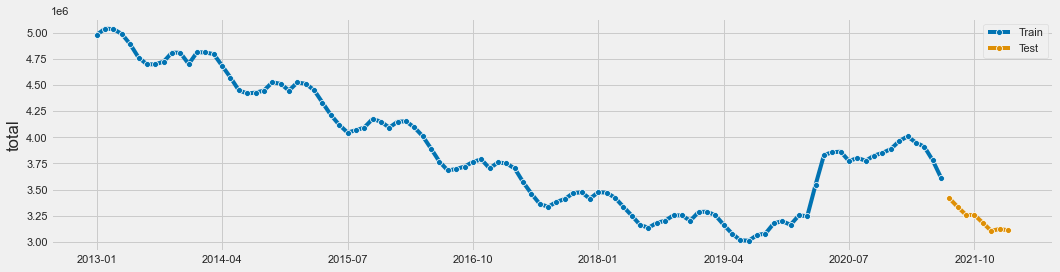

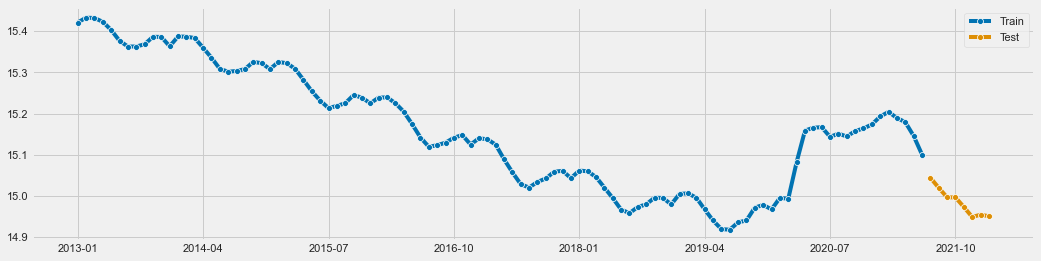

In [72]:
log_y_train, log_y_test = temporal_train_test_split(y=log_paro, test_size=8)

plot_series(y_train, y_test, labels=["Train", "Test"])

plot_series(log_y_train, log_y_test, labels=["Train", "Test"])

print(y_train.shape[0], y_test.shape[0])

In [73]:
# Estimación del horizonte temporal de predicción (forecasting horizon 'fh'):
fh = np.arange(len(y_test)) + 1 
fh

array([1, 2, 3, 4, 5, 6, 7, 8])

In [74]:
# Modelo AutoARIMA:

forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(log_y_train)

AutoARIMA(sp=12, suppress_warnings=True)

In [76]:
print(forecaster.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  102
Model:             SARIMAX(1, 1, 0)x(1, 0, [1], 12)   Log Likelihood                 279.290
Date:                              Mon, 09 May 2022   AIC                           -550.580
Time:                                      00:10:30   BIC                           -540.119
Sample:                                           0   HQIC                          -546.345
                                              - 102                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5459      0.044     12.468      0.000       0.460       0.632
ar.S.L12       0.98

Predicción de las últimas ventas por modelo AutoARIMA (en forma logarítmica):

In [77]:
log_y_pred = forecaster.predict(fh)

log_y_pred

2021-07    15.074692
2021-08    15.074662
2021-09    15.073427
2021-10    15.086877
2021-11    15.087538
2021-12    15.076999
2022-01    15.094931
2022-02    15.096394
Freq: M, dtype: float64

Predicción de las últimas ventas por modelo AutoARIMA (en forma de Serie Original):

In [78]:
paro_pred_arima = np.exp(log_y_pred)

paro_pred_arima

2021-07    3.522537e+06
2021-08    3.522432e+06
2021-09    3.518082e+06
2021-10    3.565722e+06
2021-11    3.568081e+06
2021-12    3.530674e+06
2022-01    3.594555e+06
2022-02    3.599817e+06
Freq: M, dtype: float64

**Comprobación de la precisión de las predicciones**

Realización de las funciones SKtime de precisión de la predicción

MAPE (Serie logarítmica)

In [79]:
mean_absolute_percentage_error(log_y_test, log_y_pred)

0.0065021313458801635

MAPE (Serie original)

In [80]:
mape2 = mean_absolute_percentage_error(y_test, np.exp(log_y_pred))

In [81]:
mape2

0.09760928658917321

RMSE (Serie logarítmica)

In [82]:
rmse = MeanSquaredError(square_root=True)

rmse(log_y_test, log_y_pred)

0.10521629874060139

RMSE (Serie original)

In [83]:
rmse = MeanSquaredError(square_root=True)

rmse(y_test, np.exp(log_y_pred))

353432.77331762423

Representación gráfica de las ventas pasadas y de sus respectivas predicciones:

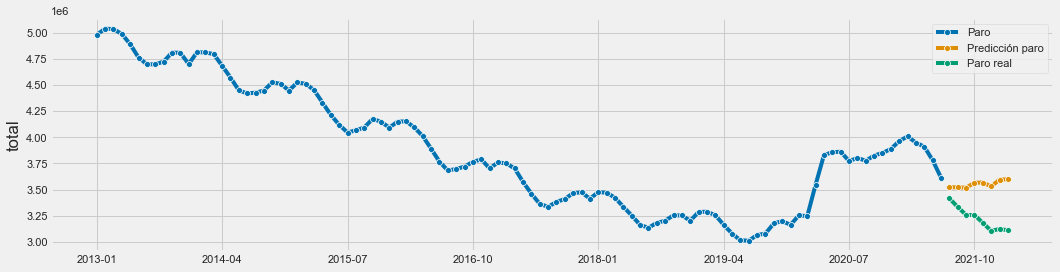

In [84]:

plot_series(y_train, paro_pred_arima, y_test, labels=["Paro", "Predicción paro", "Paro real"]);

In [ ]:
y_train, y_test = temporal_train_test_split(y = df_paro['total'].astype('float64').to_period('M'), 
                                            test_size=8)

plot_series(y_train, y_test, labels=["y_train", "y_test"])

print(y_train.shape[0], y_test.shape[0])

Se realiza el pronóstico (forecasting) del horizonte temporal de 2 años. En sp, que es el número de periodos en un ciclo estacional completo, pondremos 12 para datos mensuales con ciclo anual:

fh = np.arange(1, 7)
paro_autoets = AutoETS(auto=True, 
                       sp=12, 
                       n_jobs=-1)
paro_autoets.fit(y_train)
print(paro_autoets.summary())

paro_pred = paro_autoets.predict(fh)

print(paro_pred)

plot_series(y_train, paro_pred, y_test, labels=["Paro", "Predicción de paro", "Paro real"]);

Se hace un zoom al gráfico:

plot_series(y_train["2019":], paro_pred,y_test, labels=["Paro", "Predicción de paro", "Paro real"]);

La predicción por ETS está por encima de la línea de los datos reales, por lo que se concluye que el paro habría empeorado por debajo de dicha predicción. 

#### *Comprobación de la precisión de las predicciones (errores):*

MAPE

mape = mean_absolute_percentage_error(y_test, paro_pred)

mape

MSE

mse = MeanSquaredError()
mse(y_test, paro_pred)

RMSE

rmse = MeanSquaredError(square_root=True)
rmse(y_test, apple_pred)

Ahora se realiza el pronóstico (forecasting) del horizonte temporal de 2 años, o sea, para el 2024:

fh2 = np.arange(1, 25)

paro_autoets_pred = AutoETS(auto=True, sp=12, n_jobs=-1)

y = df_paro['total'].astype('float64').to_period('M')

paro_autoets_pred.fit(y)

print(paro_autoets_pred.summary())

#### Predicción de las ventas los 6 futuros trimestres por modelo ETS:

paro_autoets_pred.predict(fh2)

La representación gráfica de las predicciones a futuro del desempleo en España hasta febrero del 2024:

plot_series(y, paro_autoets_pred.predict(fh2), labels=["AAPL", "AAPL prediction"]);

#### Estimación del modelo de forma manual:

forecaster = ExponentialSmoothing(trend='additive', seasonal='multiplicative', sp=12)
forecaster.fit(y)

y_pred = forecaster.predict(fh2)
y_pred

print(forecaster._fitted_forecaster.summary())

forecaster.get_fitted_params()

plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Estimación del modelo de forma manual (sin componente estacional):

forecaster = ExponentialSmoothing(trend='additive',seasonal=None, sp=12)
forecaster.fit(y)

y_pred = forecaster.predict(fh2)

plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Estimación del modelo de forma manual (sin componente estacional y con tendencia multiplicativa):

forecaster = ExponentialSmoothing(trend='mul',seasonal=None, sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh2)
plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Estimación del modelo de forma manual (sin componente estacional y sin tendencia)

forecaster = ExponentialSmoothing(trend=None,seasonal=None, sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh2)
plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Estimación del modelo de forma manual (con componente estacional multiplicativo y sin tendencia):

forecaster = ExponentialSmoothing(trend=None,seasonal="mul", sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh2)
plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Estimación del modelo de forma manual (con componente estacional aditivo y sin tendencia)

forecaster = ExponentialSmoothing(trend=None,seasonal="add", sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh2)
plot_series(y, y_pred, labels=["Paro", "Predicción del paro"]);

#### Comparación del modelo con componente estacional aditivo y tendencia aditiva (con y sin dumped):

forecaster = ExponentialSmoothing(trend="add",seasonal="add",damped_trend=False, sp=12)
forecaster.fit(y)
y_pred = forecaster.predict(fh2)

forecaster = ExponentialSmoothing(trend="add",seasonal="add",damped_trend=True, sp=12)
forecaster.fit(y)
y_pred_dump = forecaster.predict(fh2)
plot_series(y["2015":], y_pred, y_pred_dump,labels=["Paro", "Predicción del paro","Predicción descartada del paro"]);

## *Modelo ARIMA*
Vimos que la serie temporal no era estacionaria ni en su media ni en su varianza, por lo que vamos a realizar los siguientes pasos:
    
    1) comparar la transformación logarítmica de la serie original y la serie en log.
    2) calcular la autocorrelación de la serie logarítmica.
    3) aplicar el modelo ARIMA
    4) (opcional) observar la precisión de los % del error de la media absoluta y del   
    error de la media al cuadrado.

Primero hacemos un resampleo con la librería de Sktime para poder operar con sus datos:

# Resample to Monthly using sktime format
paro_arima = df_paro['total'].astype('float64').to_period('M').sort_index()
paro_arima.tail()

A continuación, se realiza la transformacion logarítmica de la serie original

transformer = LogTransformer()
log_paro = transformer.fit_transform(paro_arima)
log_paro

Se comparan la **serie original** y la **serie transformada logarítmicamente** haciendo un ploteo con Sktime:

fig, ax =plot_series(paro_arima, labels=["Paro"])
ax.set_title('Paro: Serie Original');

fig, ax =plot_series(log_paro, labels=["Paro"])
ax.set_title('Paro: Transformación LOG');

Ahora pasamos al siguiente paso, que es realizar un **cálculo de la autocorrelación de la serie en logaritmos**:

plot_correlations(log_paro);

# Función de autocorrelación:
# Parámetros: d=1; D=0; S=4

transf_diff=Differencer(lags=[1])
plot_correlations(transf_diff.fit_transform(log_paro));

# Función de autocorrelación:
# Parámetros: d=0; D=1; S=4

transf_diff=Differencer(lags=[4])
plot_correlations(transf_diff.fit_transform(log_paro));

# Función de autocorrelación:
# Parámetros: d=1; D=1; S=4

transf_diff=Differencer(lags=[1,4])
plot_correlations(transf_diff.fit_transform(log_paro));

Como se hizo anteriormente, se separa la muestra en la parte de estimación (Training) y la parte de predicción (Testing):

log_y_train, log_y_test = temporal_train_test_split(y=log_paro, test_size=8)

plot_series(y_train, y_test, labels=["Train", "Test"])

plot_series(log_y_train, log_y_test, labels=["Train", "Test"])

print(y_train.shape[0], y_test.shape[0])

# Estimación del horizonte temporal de predicción (forecasting horizon 'fh'):
fh = np.arange(len(y_test)) + 1 
fh

# Modelo AutoARIMA:

forecaster = AutoARIMA(sp=12, suppress_warnings=True)

forecaster.fit(log_y_train)

print(forecaster.summary())

Predicción de las últimas ventas por modelo AutoARIMA (en forma logarítmica):

log_y_pred = forecaster.predict(fh)

log_y_pred

Predicción de las últimas ventas por modelo AutoARIMA (en forma de Serie Original):

paro_pred_arima = np.exp(log_y_pred)

paro_pred_arima

**Comprobación de la precisión de las predicciones**

Realización de las funciones SKtime de precisión de la predicción

MAPE (Serie logarítmica)

mean_absolute_percentage_error(log_y_test, log_y_pred)

MAPE (Serie original)

mape2 = mean_absolute_percentage_error(y_test, np.exp(log_y_pred))

mape2

RMSE (Serie logarítmica)

rmse = MeanSquaredError(square_root=True)

rmse(log_y_test, log_y_pred)

RMSE (Serie original)

rmse = MeanSquaredError(square_root=True)

rmse(y_test, np.exp(log_y_pred))

Representación gráfica de las ventas pasadas y de sus respectivas predicciones:


plot_series(y_train, paro_pred_arima, y_test, labels=["Paro", "Predicción paro", "Paro real"]);